In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, gc, os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, accuracy_score
import shap
import itertools

In [3]:
#Becaurse the files are too large to read,so use the parquet file format.
train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet").groupby('customer_ID').tail(4)
test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet").groupby('customer_ID').tail(4)
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,NaN,0,0.004753,0
10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,0.003238,...,-1,-1,-1,0,0,0.0,NaN,0,0.003004,0
11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,...,-1,-1,-1,0,0,0.0,NaN,0,0.006346,0
12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,...,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0
22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,0.005235,...,-1,-1,-1,0,0,0.0,NaN,0,0.003133,0


In [4]:
#shapes
train.shape, test.shape, train_labels.shape

((1802318, 190), (3656852, 190), (458913, 2))

In [5]:
print('Number of row:'+str(len(train)))
print('Number of column:'+str(len(train.columns)))

Number of row:1802318
Number of column:190


In [6]:
train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,1.788975e+06,1.802318e+06,1.802318e+06,1.801953e+06,1.802318e+06,1.474135e+06,1.801953e+06,1.801953e+06,244122.000000,1.272657e+06,...,1.802318e+06,1.802318e+06,1.802318e+06,1.802318e+06,1.802318e+06,1.769701e+06,310496.000000,1.802318e+06,1.801179e+06,1.802318e+06
mean,6.411824e-01,5.795876e+00,1.355018e-01,5.991593e-01,9.770583e-02,2.307265e-01,7.299108e-02,1.495153e-01,0.180821,1.615884e-01,...,-9.245344e-01,-9.616677e-01,-9.509687e-01,1.541842e-01,2.306419e-02,1.617967e-01,0.392772,1.540855e-01,5.163485e-02,6.143194e-01
std,2.588934e-01,1.088725e+01,2.250991e-01,4.095068e-01,2.588383e-01,1.995605e-01,2.490946e-01,2.512022e-01,0.248118,2.247142e-01,...,4.128786e-01,1.936461e-01,2.664026e-01,4.081740e-01,1.542601e-01,3.513826e-01,0.240538,4.080903e-01,1.811209e-01,2.153483e+00
min,-4.589548e-01,0.000000e+00,-7.588799e+00,9.192280e-09,3.240394e-09,-5.088831e-01,0.000000e+00,1.028956e-08,-0.000332,5.429255e-07,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-0.014539,-1.000000e+00,4.701217e-09,-1.000000e+00
25%,4.577217e-01,0.000000e+00,9.085041e-03,7.808472e-02,2.978019e-03,1.282375e-01,0.000000e+00,5.390869e-03,0.033292,4.301413e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.197211,0.000000e+00,2.749411e-03,0.000000e+00
50%,6.841134e-01,0.000000e+00,3.435712e-02,8.136464e-01,5.954595e-03,1.652470e-01,0.000000e+00,1.029428e-02,0.113116,9.156333e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.385020,0.000000e+00,5.499610e-03,0.000000e+00
75%,8.616738e-01,8.000000e+00,1.474703e-01,1.002090e+00,8.919717e-03,2.670320e-01,0.000000e+00,1.965373e-01,0.237627,1.925332e-01,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.571261,0.000000e+00,8.243219e-03,0.000000e+00
max,1.010000e+00,1.820000e+02,1.324060e+00,1.010000e+00,3.008229e+00,4.882418e+00,8.988807e+00,1.625262e+00,4.191119,1.011162e+01,...,7.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.339910e+00,2.229368,1.000000e+00,1.343326e+00,5.300000e+01


In [7]:
#count NaN or missing values in the DataFrame
print('/nCount total NaN at each column in a DataFrame: /n/n',train.isnull().sum())

/nCount total NaN at each column in a DataFrame: /n/n customer_ID          0
S_2                  0
P_2              13343
D_39                 0
B_1                  0
                ...   
D_141            32617
D_142          1491822
D_143                0
D_144             1139
D_145                0
Length: 190, dtype: int64


In [8]:
#Columns that have more than 50% of missing values
columns=train.columns[train.isna().sum()/len(train)*100>50]
columns

Index(['D_42', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_73', 'D_76', 'B_29',
       'D_88', 'D_105', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142'],
      dtype='object')

In [9]:
#Drop the columns which have more than 50% of missing values.
train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)

In [10]:
na_rate_s = train.isna().sum()/len(train)*100

na_columns= list(na_rate_s [na_rate_s > 0].index)
na_columns

['P_2',
 'B_2',
 'S_3',
 'D_41',
 'B_3',
 'D_43',
 'D_45',
 'D_46',
 'D_48',
 'B_6',
 'B_8',
 'D_52',
 'P_3',
 'D_54',
 'S_7',
 'D_55',
 'B_13',
 'D_61',
 'B_15',
 'D_62',
 'D_69',
 'D_77',
 'B_25',
 'B_26',
 'B_27',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'D_102',
 'D_104',
 'B_37',
 'R_27',
 'D_112',
 'B_40',
 'S_27',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_128',
 'D_130',
 'D_131',
 'D_133',
 'D_141',
 'D_144']

In [11]:
for column in na_columns:
    fill_value = train[column].mean()
    train[column] = train[column].fillna(fill_value)
train.isna().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_140          0
D_141          0
D_143          0
D_144          0
D_145          0
Length: 173, dtype: int64

In [12]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [13]:
#Make the changes permanent
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [14]:
#shape
train.shape, train_labels.shape, test.shape

((1802318, 174), (458913, 2), (3656852, 174))

In [15]:
categorical_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in categorical_col:
    print(train[col].unique())
    print(test[col].unique())

[ 0  1  2 -1]
[ 0  1  2 -1]
[ 2  1  5  3  7  4  6 -1]
[ 2  5  3  6  1  7  4 -1]
[ 1  0 -1]
[ 0  1 -1]
[ 0 -1  1]
[ 0 -1  1]
[ 5  0  7  2  3 -1  4  6]
[ 0  4  7  5  3  2  6 -1]
[ 0  1 -1]
[ 1  0 -1]
[ 2  1  0 -1]
[ 1  2 -1  0]
[0 3 4 5 1 2]
[0 3 4 2 1 5]
[ 0  2  3 -1  1]
[ 3  0  2 -1]
[-1  1  0]
[-1  1]
[ 6  3  5 -1  4  2  1  0]
[ 6  4  5  1  2  3 -1]


In [16]:
import calendar 
calendar.monthrange(2023,1)

(6, 31)

In [17]:
import datetime 
def get_last_day(cur_date):
    year = cur_date.year
    month = cur_date.month
    last_day = calendar.monthrange(year,month)[1]
    return datetime.date(year,month,last_day)

In [18]:
train['S_2']

0          2017-12-04
1          2018-01-11
2          2018-02-21
3          2018-03-13
4          2017-12-29
              ...    
1802313    2018-03-23
1802314    2017-12-23
1802315    2018-01-06
1802316    2018-02-06
1802317    2018-03-14
Name: S_2, Length: 1802318, dtype: object

In [19]:
train['S_2'] =pd.to_datetime(train['S_2'])


In [20]:
x = train.head(5)
x["S_2"].apply(get_last_day)

0    2017-12-31
1    2018-01-31
2    2018-02-28
3    2018-03-31
4    2017-12-31
Name: S_2, dtype: object

In [21]:
x

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
0,9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.004753,0
1,10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.003004,0
2,11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.006346,0
3,12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.002970,0
4,22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.003133,0


In [22]:
train['month_last_date'] = train['S_2'].apply(get_last_day)
train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,month_last_date
0,9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,...,-1,-1,-1,0,0,0.0,0,0.004753,0,2017-12-31
1,10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,...,-1,-1,-1,0,0,0.0,0,0.003004,0,2018-01-31
2,11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,...,-1,-1,-1,0,0,0.0,0,0.006346,0,2018-02-28
3,12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,...,-1,-1,-1,0,0,0.0,0,0.002970,0,2018-03-31
4,22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,...,-1,-1,-1,0,0,0.0,0,0.003133,0,2017-12-31


In [23]:
customer_last_date_series=train.groupby(by=['customer_ID','month_last_date'])['customer_ID'].count()
customer_last_date_series.sort_values(ascending=False)

customer_ID                                                       month_last_date
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a  2017-12-31         1
aa57eca7fc5e5b34cb0a588b74b29b6a2184f17093e41db896c3ed5d1e34fe95  2018-02-28         1
aa5856a7d39b5b76f80758def06c5e2b5098c070659e54b24a555029ed04436d  2018-01-31         1
                                                                  2017-12-31         1
aa5847601c3004708cc33c4d40b92e1acddca651658d9b6292e99438cc26be36  2018-03-31         1
                                                                                    ..
551f6eb7b1a98229573ba6503d6991fb982ab6074e3ff988924600a40106c873  2018-03-31         1
                                                                  2018-02-28         1
                                                                  2018-01-31         1
                                                                  2017-12-31         1
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba

In [24]:
month_customer_df = train.groupby(by='month_last_date')['customer_ID'].count().reset_index()
month_customer_df.columns = ['month_last_date','customer_number']
month_customer_df

,month_last_date,customer_number
0,2017-03-31,138
1,2017-04-30,225
2,2017-05-31,609
3,2017-06-30,593
4,2017-07-31,196
5,2017-08-31,326
6,2017-09-30,564
7,2017-10-31,1215
8,2017-11-30,1593
9,2017-12-31,438910


In [25]:
train = pd.merge(left = train,right=train_labels,how='inner',on='customer_ID')
train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,month_last_date,target
0,9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,...,-1,-1,0,0,0.0,0,0.004753,0,2017-12-31,0
1,10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,...,-1,-1,0,0,0.0,0,0.003004,0,2018-01-31,0
2,11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,...,-1,-1,0,0,0.0,0,0.006346,0,2018-02-28,0
3,12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,...,-1,-1,0,0,0.0,0,0.002970,0,2018-03-31,0
4,22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,...,-1,-1,0,0,0.0,0,0.003133,0,2017-12-31,0


In [26]:
train_labels['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int64

In [27]:
month_default_df = train[train['target']==1].groupby(by='month_last_date')['customer_ID'].count().reset_index()
month_default_df.columns = ['month_last_date','default_number']
month_default_df.head()

,month_last_date,default_number
0,2017-03-31,25
1,2017-04-30,40
2,2017-05-31,98
3,2017-06-30,121
4,2017-07-31,47


In [28]:
counter_df=pd.merge(left=month_customer_df,right=month_default_df,how ='outer',on='month_last_date')
counter_df

,month_last_date,customer_number,default_number
0,2017-03-31,138,25
1,2017-04-30,225,40
2,2017-05-31,609,98
3,2017-06-30,593,121
4,2017-07-31,196,47
5,2017-08-31,326,77
6,2017-09-30,564,122
7,2017-10-31,1215,220
8,2017-11-30,1593,566
9,2017-12-31,438910,112520


In [29]:
counter_df['pd_rate'] = counter_df['default_number'] / counter_df['customer_number']
counter_df

,month_last_date,customer_number,default_number,pd_rate
0,2017-03-31,138,25,0.181159
1,2017-04-30,225,40,0.177778
2,2017-05-31,609,98,0.160920
3,2017-06-30,593,121,0.204047
4,2017-07-31,196,47,0.239796
5,2017-08-31,326,77,0.236196
6,2017-09-30,564,122,0.216312
7,2017-10-31,1215,220,0.181070
8,2017-11-30,1593,566,0.355304
9,2017-12-31,438910,112520,0.256362


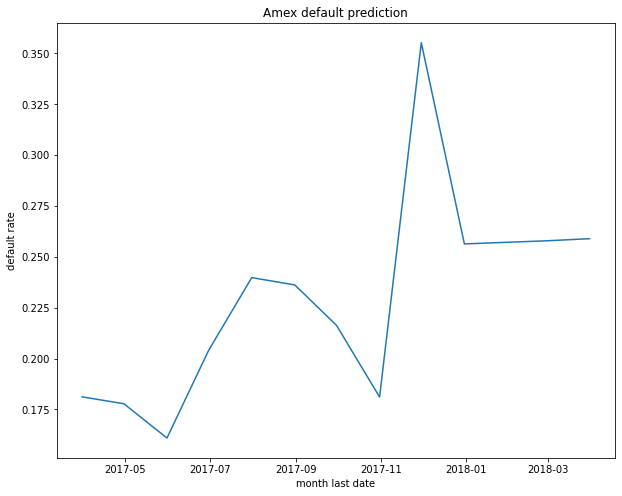

In [30]:
plt.figure(figsize = (10,8))
plt.plot(counter_df['month_last_date'],counter_df['pd_rate'])
plt.xlabel('month last date')
plt.ylabel('default rate')
plt.title('Amex default prediction')
plt.show()